# Load necessary packages

In [1]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import models, transforms

from PIL import Image
from io import BytesIO
import requests
import matplotlib.pyplot as plt
%matplotlib inline

# VGG19

In [2]:
vgg = models.vgg19(pretrained=True)
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /tmp/.torch/models/vgg19-dcbb9e9d.pth
574673361it [00:12, 47573722.78it/s]


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [4]:
from urllib.request import urlretrieve
import json

classes_url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
classes_path = "imagenet_class_index.json"
urlretrieve(classes_url, classes_path)

class_idx = json.load(open(classes_path))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [5]:
idx2label[:5]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']

In [6]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    response = requests.get(img_path)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    image = image.to(device)
    return image

In [7]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def plot_image(tensor, title=''):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    plt.imshow(image)
    plt.title(title)

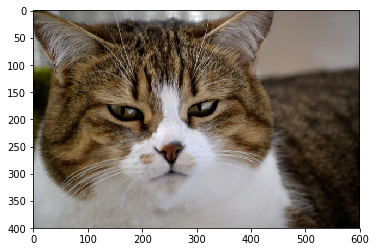

In [8]:
image = load_image("https://upload.wikimedia.org/wikipedia/commons/thumb/0/0b/Plume_the_Cat.JPG/800px-Plume_the_Cat.JPG")
plot_image(image)

In [9]:
def predict(model, image_tensor, topk=5):
    model.eval()
    probs = F.softmax(model(image_tensor), dim=1)
    probs, classes = probs.topk(topk, dim=1)
    probs, classes = probs.to("cpu"), classes.to("cpu")
    for idx, c in enumerate(classes[0]):
        print("class ", idx2label[c], " with probality: ", probs[0,idx].item())

In [10]:
predict(vgg, image, 5)

class  tiger_cat  with probality:  0.41711416840553284
class  tabby  with probality:  0.2770276367664337
class  Egyptian_cat  with probality:  0.15219813585281372
class  lynx  with probality:  0.04337255284190178
class  Persian_cat  with probality:  0.0055458154529333115


In [11]:
def train(model, target_image, target_class, n_epochs, print_every,lr=0.01):
    optimizer = optim.Adam([target_image], lr=lr)
    for epoch in range(n_epochs):
        probs = F.softmax(vgg(target_image), dim=1)
        loss = - probs[0, target_class]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(epoch%print_every==0):
            print("Epoch :", epoch+1, "Loss :", -loss.item())

In [12]:
target_class = idx2label.index("goldfish")
target_image = image.clone()
target_image.requires_grad = True

n_epochs = 5
print_every = 1
lr = 0.01
train(vgg, target_image, target_class, n_epochs, print_every,lr)

Epoch : 1 Loss : 2.1988713342580013e-05
Epoch : 2 Loss : 0.00038438846240751445
Epoch : 3 Loss : 0.0024942769668996334
Epoch : 4 Loss : 0.024831626564264297
Epoch : 5 Loss : 0.37008151412010193


In [13]:
predict(vgg, target_image)

class  goldfish  with probality:  0.9501152038574219
class  axolotl  with probality:  0.015854783356189728
class  puffer  with probality:  0.01041480153799057
class  terrapin  with probality:  0.0015287253772839904
class  hummingbird  with probality:  0.001404278795234859


# ResNet

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /tmp/.torch/models/resnet152-b121ed2d.pth
241530880it [00:02, 86196258.35it/s]


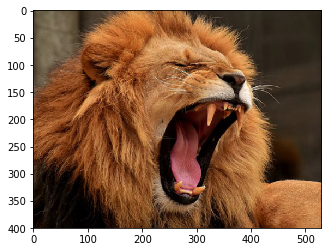

In [14]:
resNet = models.resnet152(pretrained=True).to(device)
for param in resNet.parameters():
    param.requires_grad_(False)
image = load_image("https://cdn.pixabay.com/photo/2018/04/13/21/24/lion-3317670__340.jpg")
plot_image(image)

In [15]:
predict(resNet, image)

class  lion  with probality:  0.8144826292991638
class  chow  with probality:  0.028263647109270096
class  Tibetan_mastiff  with probality:  0.0064504616893827915
class  dhole  with probality:  0.006292800884693861
class  cheetah  with probality:  0.005379433743655682


In [16]:
target_class = idx2label.index("chow")

target_image = image.clone()
target_image.requires_grad_(True)

n_epochs = 5
print_every = 1
lr = 0.01
train(resNet, target_image, target_class, n_epochs, print_every,lr)

Epoch : 1 Loss : 0.00287600327283144
Epoch : 2 Loss : 0.4329831600189209
Epoch : 3 Loss : 0.9869375824928284
Epoch : 4 Loss : 0.9969743490219116
Epoch : 5 Loss : 0.9984686970710754


In [17]:
predict(resNet, target_image)

class  lion  with probality:  0.8013833165168762
class  chow  with probality:  0.04352477192878723
class  Tibetan_mastiff  with probality:  0.005980111658573151
class  Persian_cat  with probality:  0.005620184820145369
class  llama  with probality:  0.005482381209731102
